### Import libraries

In [67]:
import numpy as np
import copy
import random

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import as_float_array

import tjl_dense_numpy_tensor as te
import tjl_hall_numpy_lie as li
from tosig import *

### Define Signature estimator

In [58]:
class SignatureTransform(BaseEstimator, TransformerMixin):
    
    def __init__(self, order):
        if not isinstance(order, int) or order<1:
            raise NameError('The order must be a positive integer.')
        self.order = order
        
    def fit(self, X, y=None):
        return self
                            
    def transform(self, X, y=None):
        return np.array([stream2sig(item, self.order) for item in X])

### Simulate brownian paths

In [71]:
# Make a list of total_observations path_dim-dimensional brownian paths 
total_observations = 10
path_dim = 3
brownian_paths = []
for k in range(total_observations):
    brownian_paths.append(te.brownian(100, path_dim))

### Test AddTime estimator

In [72]:
class AddTime(BaseEstimator, TransformerMixin):
    def __init__(self, init_time=0., total_time=1.):
        self.init_time = init_time
        self.total_time = total_time

    def fit(self, X, y=None):
        return self

    def transform_instance(self, X):
        t = np.linspace(self.init_time, self.init_time + 1, len(X))
        return np.c_[t, X]

    def transform(self, X, y=None):
        return [self.transform_instance(x) for x in X]

In [73]:
add_time = AddTime()
X_addtime = add_time.fit_transform(brownian_paths)

In [74]:
X_addtime

[array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 1.00000000e-02, -2.11034373e-01, -1.17825544e-01,
         -1.98322383e-02],
        [ 2.00000000e-02, -2.56690648e-01, -8.31602613e-02,
          5.96774058e-02],
        [ 3.00000000e-02, -3.75040302e-01, -4.56577445e-02,
         -5.83158504e-04],
        [ 4.00000000e-02, -4.39390443e-01, -1.95914178e-01,
         -9.48877348e-02],
        [ 5.00000000e-02, -3.67179228e-01, -2.94185781e-01,
         -1.88600359e-01],
        [ 6.00000000e-02, -3.68017987e-01, -1.07885239e-01,
         -3.41410153e-01],
        [ 7.00000000e-02, -2.62445285e-01, -1.93331141e-01,
         -3.77170709e-01],
        [ 8.00000000e-02, -2.58017400e-02, -1.77258976e-01,
         -3.70257432e-01],
        [ 9.00000000e-02, -4.68394661e-02, -7.18715880e-02,
         -3.85667286e-01],
        [ 1.00000000e-01,  7.36356059e-02,  8.09719832e-02,
         -3.71112973e-01],
        [ 1.10000000e-01,  7.39660330e-02, 

In [75]:
d = 2
Sigs = SignatureTransform(order=d)
sigs_addtime = Sigs.fit_transform(X_addtime)

In [76]:
sigs_addtime.shape

(10, 21)

### Test Reversion estimator

In [68]:
class Reversion(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [as_float_array(x[::-1]) for x in X]

In [108]:
reverse = Reversion()
X_reversed = reverse.fit_transform(brownian_paths)

In [118]:
[np.sum(np.subtract(i,j[::-1])) for i, j in zip(brownian_paths, X_reversed)]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

### Test LeadLag

In [198]:
class LeadLag(BaseEstimator, TransformerMixin):
    
    def __init__(self, dimensions_to_lag):
        if not isinstance(dimensions_to_lag, list):
            raise NameError('dimensions_to_lag must be a list')
        self.dimensions_to_lag = dimensions_to_lag

    def fit(self, X, y=None):
        return self

    def transform_instance_1D(self, x):
        
        lag = []
        lead = []

        for val_lag, val_lead in zip(x[:-1], x[1:]):
            lag.append(val_lag)
            lead.append(val_lag)
            lag.append(val_lag)
            lead.append(val_lead)

        lag.append(x[-1])
        lead.append(x[-1])

        return lead, lag

    def transform_instance_multiD(self, X):
        if not all(i < X.shape[1] and isinstance(i, int) for i in self.dimensions_to_lag):
            error_message = 'the input list "dimensions_to_lag" must contain integers which must be' \
                            ' < than the number of dimensions of the original feature space'
            raise NameError(error_message)
        
        lead_components = []
        lag_components = []

        for dim in range(X.shape[1]):
            lead, lag = self.transform_instance_1D(X[:, dim])
            lead_components.append(lead)
            if dim in self.dimensions_to_lag:
                lag_components.append(lag)

        return np.c_[lead_components + lag_components].T
    
    def transform(self, X, y=None):
        return [self.transform_instance_multiD(x) for x in X]

### Example with one Brownian Paths

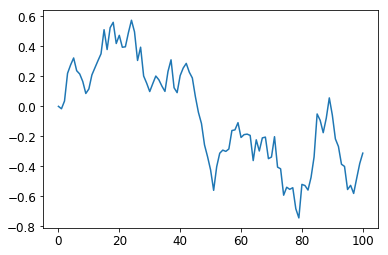

In [164]:
s = te.brownian(100, 1)
plt.plot(s)
plt.show()

In [166]:
lead_lag = LeadLag(dimensions_to_lag=[0])
X_leadlag = lead_lag.fit_transform([s])

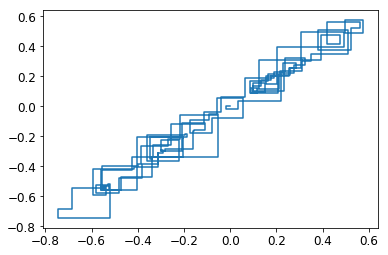

In [175]:
plt.plot([i[0] for i in X_leadlag[0]], [i[1] for i in X_leadlag[0]])
plt.show()

### Example with multiple Brownian Paths

In [177]:
brownian_paths[0].shape

(101, 3)

In [221]:
dimensions_to_lag = [0, 2]
lead_lag = LeadLag(dimensions_to_lag)
X_leadlag = lead_lag.fit_transform(brownian_paths)

In [222]:
X_leadlag[0]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.21103437, -0.11782554, -0.01983224,  0.        ,  0.        ],
       [-0.21103437, -0.11782554, -0.01983224, -0.21103437, -0.01983224],
       ...,
       [-0.37192641, -0.14220476, -0.86141707, -0.37192641, -0.86141707],
       [-0.46697838, -0.07696287, -0.82366639, -0.37192641, -0.86141707],
       [-0.46697838, -0.07696287, -0.82366639, -0.46697838, -0.82366639]])

In [223]:
X_leadlag[0].shape

(201, 5)

In [224]:
path_dim = 3

In [225]:
d

2

In [226]:
ind = np.random.randint(0, path_dim-1)

In [228]:
stream2sig(X_leadlag[ind], d).shape[0] == 1+(path_dim+len(dimensions_to_lag))+(path_dim+len(dimensions_to_lag))**2

True

In [279]:
from sklearn.pipeline import Pipeline
from sklearn import linear_model

pipeline = Pipeline([('lead_lag_transform', LeadLag(dimensions_to_lag=[1, 2])),
                     ('signature_transform', SignatureTransform(order=2)),
                     ('clf', linear_model.SGDClassifier(max_iter=1000)),
                    ])

In [280]:
y = np.random.randint(0, 10, total_observations)

In [281]:
results = pipeline.fit(brownian_paths, y)

In [282]:
from sklearn.model_selection import GridSearchCV

param_grid = {'lead_lag_transform__dimensions_to_lag': [[0], [1], [2], [0,1], [0,2], [1,2]],
              'signature_transform__order': [2, 3, 4],
              'clf__max_iter': [1000, 5000, 10000]
             }
search = GridSearchCV(pipeline, param_grid, iid=False, cv=2, return_train_score=False)

In [283]:
search.fit(brownian_paths, y)

c:\users\cristopher\source\repos\learnpytorch\tm001\env\lib\site-packages\sklearn\model_selection\_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('lead_lag_transform', LeadLag(dimensions_to_lag=[1, 2])), ('signature_transform', SignatureTransform(order=2)), ('clf', SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='o...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'lead_lag_transform__dimensions_to_lag': [[0], [1], [2], [0, 1], [0, 2], [1, 2]], 'signature_transform__order': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=0)

In [284]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.208):
{'lead_lag_transform__dimensions_to_lag': [0, 1], 'signature_transform__order': 3}
